In [0]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install catboost

In [0]:
!pip install xgboost

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import xgboost as xgb
import operator
from catboost import Pool, CatBoostClassifier
import lightgbm as lgb
import requests
from bs4 import BeautifulSoup
from datetime import datetime

# Processed Subsample  파일 추출

In [0]:
#Subsample Data.
df_sub = pd.read_csv('/content/drive/My Drive/airbnb-recruiting-new-user-bookings/USE_THIS_subsample_train_users.csv')
df_sub = df_sub.drop(['id'], axis=1)
df_sub.head()

,age,country_destination,dac_month,dac_day,tfa_month,tfa_day,tfa_time,dac_pred_diff,tfa_pred_diff,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,signup_method_facebook,signup_method_google,signup_method_weibo,signup_flow_0,signup_flow_1,signup_flow_2,signup_flow_3,signup_flow_4,signup_flow_5,signup_flow_6,signup_flow_8,signup_flow_10,signup_flow_12,signup_flow_14,signup_flow_15,signup_flow_16,signup_flow_20,signup_flow_21,signup_flow_23,signup_flow_24,signup_flow_25,language_-unknown-,language_ca,language_cs,language_da,language_de,language_el,...,first_browser_Yandex.Browser,first_browser_wOSBrowser,dac_weekday_Friday,dac_weekday_Monday,dac_weekday_Saturday,dac_weekday_Sunday,dac_weekday_Thursday,dac_weekday_Tuesday,dac_weekday_Wednesday,dac_season_fall,dac_season_spring,dac_season_summer,dac_season_winter,tfa_season_fall,tfa_season_spring,tfa_season_summer,tfa_season_winter,tfa_weekday_Friday,tfa_weekday_Monday,tfa_weekday_Saturday,tfa_weekday_Sunday,tfa_weekday_Thursday,tfa_weekday_Tuesday,tfa_weekday_Wednesday,tfa_trange_afternoon,tfa_trange_dawn,tfa_trange_evening,tfa_trange_morning,tfa_trange_night,dac_year_2010,dac_year_2011,dac_year_2012,dac_year_2013,dac_year_2014,tfa_year_2009,tfa_year_2010,tfa_year_2011,tfa_year_2012,tfa_year_2013,tfa_year_2014
0,6.369697,CA,-0.006939,0.129377,-0.006916,0.129403,1.211201,0.025409,0.024726,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
1,2.515123,NL,1.228894,-1.243607,1.228989,-1.243663,0.466449,1.090954,1.089647,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,-0.023255,NDF,-0.315897,0.129377,-0.315893,0.129403,1.087075,-1.040136,-1.040195,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
3,-0.963395,DE,-0.933814,-0.442699,-0.933846,-0.442708,-1.519556,-1.040136,-1.040195,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
4,-0.023255,ES,-0.315897,0.014962,-0.315893,0.014981,0.714700,1.090954,1.089647,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0


# Finding HyperParameter with Random Search

## Split data to Train & Test

In [0]:
# data 나누기
y = df_sub.country_destination
df_sub = df_sub.drop(['country_destination'], axis=1)
X = df_sub

## Logistic Regression
#### 참고 : https://chrisalbon.com/machine_learning/model_selection/hyperparameter_tuning_using_grid_search/

In [0]:
from sklearn.linear_model import LogisticRegression
from pprint import pprint
lr = LogisticRegression()

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(lr.get_params())

Parameters currently in use:

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'warn',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [0]:
#Random Hyperparameter Grid
lr_random_grid = {
        'penalty': ['l1', 'l2'],
        'C': [0.001,0.01,0.1,1,10,100]
        }

In [0]:
folds = 3
param_comb = 5
lr_random = RandomizedSearchCV(lr, param_distributions=lr_random_grid, n_iter=param_comb, n_jobs=4, cv=3, verbose=2, random_state=1001 )
# Fit the random search model
lr_random.fit(X, y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   51.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='warn', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='warn', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='warn', n_iter=5, n_jobs=4,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                                        'penalty': ['l1', 'l2']},
                   pre_dispatch='2*n_jobs', random_state=1001, refit=True,
                   return_train_score=False, scoring=None,

In [0]:
lr_random.best_params_

{'C': 1, 'penalty': 'l1'}

In [0]:
lr_random.best_score_

0.12939722380680738

## RandomForest
####  참고 : nexters.me/om

### Defualt value check

In [0]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestClassifier()
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


### Random Hyperparameter Grid

In [0]:
#To use RandomizedSearchCV, 
#we first need to create a parameter grid to sample from during fitting:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
rf_random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(rf_random_grid)

# Altogether, there are 2 * 12 * 2 * 3 * 3 * 10 = 4320 settings! 

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


### Random Search Training

In [0]:
# Use the random grid to search for best hyperparameters

from sklearn.ensemble import RandomForestClassifier

# First create the base model to tune

rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 10 different combinations, and use all available cores

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = rf_random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X, y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarnin

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [0]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 200}

### Evaluate Random Search

In [0]:
best_random = rf_random.best_estimator_ #best model
rf_random.best_score_

0.13586233124168093

## XGBoost
#### 참고 : https://www.kaggle.com/kenji19840210/hyperparameter-grid-search-with-xgboost

In [0]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [0]:
#Random Hyperparameter Grid

xgb_random_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [0]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='multi:softprob',
                    silent=True, nthread=1)

In [0]:
param_comb = 5
xgb_random = RandomizedSearchCV(xgb, param_distributions=xgb_random_grid, n_iter=param_comb,n_jobs=4, cv=3, verbose=2, random_state=1001)
# Fit the random search model
xgb_random.fit(X, y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


In [0]:
xgb_random.best_params_

In [0]:
xgb_random.best_score_

## LGBM 

In [0]:
import lightgbm as lgb
fit_params={"early_stopping_rounds":30, 
            #'eval_metric':
            "eval_set" : [(X_val,y_val)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [0]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'task': ['train'],
    'boosting_type': ['gbdt'],
    'objective':['multiclass'],
    'num_class':[12],
    'metric': ['multi_logloss'],
    'learning_rate': [0.01,0.1,0.5],
    'max_depth': [5,8,10],
    'num_leaves': [10,15,50],
    'feature_fraction': [0.6],
    'bagging_fraction': [0.6],
    'bagging_frequency': [17]}

In [0]:
n_HP_points_to_test = 100

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=-1, n_estimators=5000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

In [0]:
gs.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

## CatBoost

In [0]:
model = CatBoostClassifier(iterations=95, learning_rate=0.1, depth=5,task_type='GPU',loss_function='MultiClass',eval_metric='MultiClass') 

#메뉴얼하게 튜닝

In [0]:
model.fit(X_train,y_train,plot=True)

## Deep Neural Net

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential 
from keras.layers import Dense 
from keras.layers import Activation
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
NFOLDS = 3
SEED = 0
NROWS = None
kf = KFold(n_splits = NFOLDS, shuffle=True, random_state=SEED)

In [0]:
from keras.utils import multi_gpu_model
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from sklearn.utils import class_weight

from keras.regularizers import l1

In [0]:
import os
checkpoint_path = "/content/drive/My Drive/cp10.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 체크포인트 콜백 만들기
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [0]:
X=df_all.values
X_test = df_test.drop(['id','country_destination'], axis=1).values

In [0]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_y)

In [0]:
x_tra,x_val,y_tra,y_val=train_test_split(X, dummy_y, test_size=0.2, random_state=42)

In [0]:
model = Sequential()

model.add(Dense(128,activity_regularizer=l1(0.001),init='glorot_uniform',input_dim=X.shape[1]))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(64,activity_regularizer=l1(0.001),init='glorot_uniform'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(32,activity_regularizer=l1(0.001),init='glorot_uniform'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(12, activation = 'softmax',init='glorot_uniform'))

model.compile(loss = 'categorical_crossentropy' , optimizer = 'adam' , metrics = ['categorical_accuracy'] )


##메뉴얼하게 튜닝

In [0]:
#model.load_weights(checkpoint_path)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)
hist = model.fit(x_tra, y_tra, epochs = 30, batch_size = 100,validation_data = (x_val, y_val),callbacks = [cp_callback,early_stop])

# Modeling

In [0]:
# data 불러오기
df_train = pd.read_csv('/content/drive/My Drive/airbnb-recruiting-new-user-bookings/USE_THIS_processed_train_users.csv')
df_test = pd.read_csv('/content/drive/My Drive/airbnb-recruiting-new-user-bookings/USE_THIS_processed_test_users.csv')

## Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C= 1, penalty= 'l1')

lr.fit(X, y)
y_pred = lr.predict_proba(X_test)  

#Taking the 5 classes with highest probabilities
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

#Generate submission
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv("/content/drive/My Drive/airbnb-recruiting-new-user-bookings/lr_sub.csv", index=False)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [0]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
labels = df_train['country_destination'].values
y = le.fit_transform(labels)


df_train = df_train.drop(['country_destination', 'id'], axis=1)
X = df_train
# test id 따로 저장
id_test = df_test.id
X_test = df_test.drop(['id','country_destination'], axis=1)

## Random Forest

In [0]:
#Classifier with Hyperparmeter
rf = RandomForestClassifier(bootstrap = True, max_depth= 10,max_features= 'sqrt', min_samples_leaf= 2,min_samples_split= 5,n_estimators= 200)

rf.fit(X, y)
y_pred = rf.predict_proba(X_test)  


#Taking the 5 classes with highest probabilities
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

#Generate submission
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv("/content/drive/My Drive/airbnb-recruiting-new-user-bookings/rf_sub.csv", index=False)

### feature importance

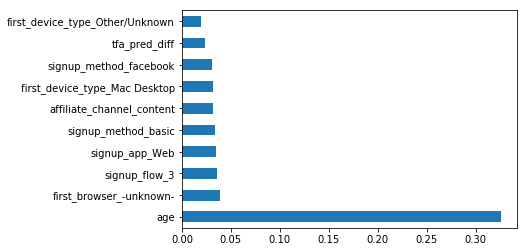

In [0]:
feat_importances = pd.Series(rf.feature_importances_, index=df_train.columns)
feat_importances.nlargest(10).plot(kind='barh')

## XGBoost

In [0]:
#Classifier with Hyperparmeter
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='multi:softprob', silent=True, nthread=1)

xgb.fit(X, y)
y_pred = xgb.predict_proba(X_test)  


#Taking the 5 classes with highest probabilities
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

#Generate submission
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv("/content/drive/My Drive/airbnb-recruiting-new-user-bookings/xgb_sub.csv", index=False)

### feature importance

In [0]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plot_importance(xgb, max_num_features = 10)
plt.show()

## LGBM

In [0]:
lgb_train = lgb.Dataset(X, y)

In [0]:
params={'task': 'train', 'objective': 'multiclass', 'num_leaves': 10, 'num_class': 12, 'metric': 'multi_logloss', 'max_depth': 5, 'learning_rate': 0.01, 'feature_fraction': 0.6, 'boosting_type': 'gbdt', 'bagging_frequency': 17, 'bagging_fraction': 0.6} 

In [0]:
lgbm_model = lgb.train(params, train_set = lgb_train)
y_pred = lgbm_model.predict(X_test)  

In [0]:
import seaborn as sns

feature_imp_lgbm = pd.DataFrame((zip(lgbm_model.feature_importance(),X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(5, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp_lgbm.sort_values(by="Value", ascending=False)[:10])
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [0]:
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

#Generate submission
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv("/content/drive/My Drive/airbnb-recruiting-new-user-bookings/lgb_sub.csv", index=False)

## CatBoost

In [0]:
model = CatBoostClassifier(iterations=95, learning_rate=0.1, depth=5,task_type='GPU',loss_function='MultiClass',eval_metric='MultiClass') 

In [0]:
model.fit(X,y,plot=True)
y_pred = model.predict_proba(X_test)  

In [0]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Catboost",fontsize=15)

In [0]:
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

#Generate submission
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv("/content/drive/My Drive/airbnb-recruiting-new-user-bookings/cat_sub.csv", index=False)

## Deep Neural Net

In [0]:
import os
checkpoint_path = "/content/drive/My Drive/cp10.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 체크포인트 콜백 만들기
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

X=df_all.values
X_test = df_test.drop(['id','country_destination'], axis=1).values

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_y)

x_tra,x_val,y_tra,y_val=train_test_split(X, dummy_y, test_size=0.2, random_state=42)

model = Sequential()

model.add(Dense(128,activity_regularizer=l1(0.001),init='glorot_uniform',input_dim=X.shape[1]))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(64,activity_regularizer=l1(0.001),init='glorot_uniform'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(32,activity_regularizer=l1(0.001),init='glorot_uniform'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(12, activation = 'softmax',init='glorot_uniform'))

model.compile(loss = 'categorical_crossentropy' , optimizer = 'adam' , metrics = ['categorical_accuracy'] )


##메뉴얼하게 튜닝

#model.load_weights(checkpoint_path)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)
hist = model.fit(x_tra, y_tra, epochs = 30, batch_size = 100,validation_data = (x_val, y_val),callbacks = [cp_callback,early_stop])

In [0]:
y_pred=model.predict_proba(X_test)
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

# Generate submission
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv('/content/drive/My Drive/dnn.csv',index=False)

## Stacking_1st layer

In [0]:
import pandas as pd
import numpy as np
from scipy.stats import skew
import xgboost as xgb
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from math import sqrt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import gc
NFOLDS = 3
SEED = 0
NROWS = None
kf = KFold(n_splits = NFOLDS, shuffle=True, random_state=SEED)

In [0]:
class CatboostWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_seed'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)

In [0]:
class LightGBMWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['feature_fraction_seed'] = seed
        params['bagging_seed'] = seed
        self.clf = clf(**params)
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)

In [0]:
def get_oof(clf):
    oof_train = np.zeros((x_train.shape[0],12))
    oof_test = np.zeros((x_test.shape[0],12))
    oof_test_skf = np.empty((NFOLDS, x_test.shape[0],12))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train, oof_test

In [0]:
catboost_params_1 = {
    'iterations':95,
    'learning_rate':0.1,
    'random_strength':0.1,
    'task_type':'GPU',
    'depth':5,
    'loss_function':'MultiClass',
    'eval_metric':'MultiClass'
    }

In [0]:
catboost_params_2 = {
    'iterations':95,
    'learning_rate':0.01,
    'random_strength':0.1,
    'task_type':'GPU',
    'depth':5,
    'loss_function':'MultiClass',
    'eval_metric':'MultiClass'
    }

In [0]:
lightgbm_params  = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class':12,
    'metric': 'multi_logloss',
    'learning_rate': 0.01,
    'max_depth': 5,
    'num_leaves': 10,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.6,
    'bagging_freq': 17}

In [0]:
cb_1 = CatboostWrapper(clf= CatBoostClassifier, seed = SEED, params=catboost_params_1)
cb_2= CatboostWrapper(clf= CatBoostClassifier, seed = SEED, params=catboost_params_2)
lg = LightGBMWrapper(clf = LGBMClassifier, seed = SEED, params = lightgbm_params)

In [0]:
cb_oof_train_1, cb_oof_test_1 = get_oof(cb_1)
cb_oof_train_2, cb_oof_test_2 = get_oof(cb_2)
lg_oof_train, lg_oof_test = get_oof(lg)

In [0]:
X_train = np.concatenate((cb_oof_train_2, cb_oof_train_1,lg_oof_train), axis=1)
X_test = np.concatenate((cb_oof_test_2, cb_oof_test_1,lg_oof_test), axis=1)

## Stacking_2nd_layer(Randomforest)

In [0]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [70,80,90,100]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [60,70,80,90]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier(random_state = 42)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
model=rf_random.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test) 

print(y_pred)

# We take the 5 highest probabilities for each person
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx]*5
    cts += le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv('/content/drive/My Drive/stacking_forest.csv',index=False)

## Stacking_2nd_layer(NeuralNet)

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential 
from keras.layers import Dense 
from keras.layers import Activation
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.utils import shuffle
from keras.utils import multi_gpu_model
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from sklearn.utils import class_weight

from keras.regularizers import l1
# instantiate regularizer
reg = l1(0.001)

In [0]:
model = Sequential()


#model.add(Dense(256,activity_regularizer=l1(0.001),init='glorot_uniform',input_dim=X_train.shape[1]))
#model.add(Activation('relu'))
#model.add(Dropout(0.5))

model.add(Dense(64,activity_regularizer=l1(0.001),init='glorot_uniform',input_dim=X_train.shape[1]))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(32,activity_regularizer=l1(0.001),init='glorot_uniform'))
model.add(BatchNormalization(epsilon=1e-06, mode=0, momentum=0.9, weights=None))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(12, activation = 'softmax',init='glorot_uniform'))

model.compile(loss = 'categorical_crossentropy' , optimizer = 'adam' , metrics = ['categorical_accuracy'] )

In [0]:
import os
checkpoint_path = "/content/drive/My Drive/cp9.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 체크포인트 콜백 만들기
cp_callback = tf.keras.callbacks.MbodelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y = encoder.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_y)

x_tra,x_val,y_tra,y_val=train_test_split(X_train, dummy_y, test_size=0.2, random_state=42)

In [0]:
#model.load_weights(checkpoint_path)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)
hist = model.fit(x_tra, y_tra, epochs = 30, batch_size = 10,validation_data = (x_val, y_val),callbacks = [cp_callback,early_stop])

In [0]:
y_pred=model.predict_proba(X_test)
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

# Generate submission
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv('/content/drive/My Drive/stackeddnn_8.csv',index=False)